In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

# Standard Imports
%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import scipy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import os
import glob
import seaborn as sns
import warnings
import datetime
warnings.simplefilter(action='ignore', category=FutureWarning)

# ESIO Imports

from esio import EsioData as ed
from esio import import_data
from esio import ice_plot

In [2]:
# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
E = ed.EsioData.load()
# Directories
all_models=['nicosipn']
runType='forecast'
updateall = True

In [4]:
stero_grid_file = E.obs['NSIDC_0051']['grid']
obs_grid = import_data.load_grid_info(stero_grid_file, model='NSIDC')
# Ensure latitude is within bounds (-90 to 90)
# Have to do this because grid file has 90.000001
obs_grid['lat_b'] = obs_grid.lat_b.where(obs_grid.lat_b < 90, other = 90)

In [5]:
obs_grid

<xarray.Dataset>
Dimensions:  (ni: 448, ni_b: 449, nj: 304, nj_b: 305)
Coordinates:
  * nj       (nj) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * ni       (ni) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * nj_b     (nj_b) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * ni_b     (ni_b) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Data variables:
    lat      (nj, ni) float64 31.1 31.25 31.4 31.55 31.69 31.84 31.99 32.13 ...
    lon      (nj, ni) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 ...
    lat_b    (nj_b, ni_b) float64 31.13 31.28 31.42 31.57 31.72 31.86 32.01 ...
    lon_b    (nj_b, ni_b) float64 168.5 168.6 168.7 168.8 168.9 169.0 169.2 ...
    imask    (nj, ni) bool True True True True True True True True True True ...

In [6]:
def load_sun_extent(f, valid_time):
    #extent maps in uint8
    with open( f, 'rb') as frr:
        extentforecast = np.fromfile(frr, dtype=np.uint8)
    extentforecast = extentforecast.reshape(448, 304)
    da = xr.DataArray(extentforecast, dims=('ni','nj')).T
    oceanmask = da<255 # Mask land
    da = (da==250).astype('int').where(oceanmask)
    da.coords['valid_time'] = valid_time
    
    return da
    

In [7]:
cvar = 'SIC'

# Pre 2018 July
prefix_single = ['SIPN2_Extent_over']
# Post 2018 July
ens_prefix = ['SIPN2_SIC_High','SIPN2_SIC_Low','SIPN2_SIC_Mean']

In [8]:
for model in all_models:
    print('Regridding ', model, '...')
    
    data_dir = os.path.join('/home/disk/sipn/upload',model,runType) 
    data_out = '/home/disk/sipn/nicway/data/model/nicosipn/forecast/sipn_nc'
   
    # Get list of dir ("months")
    mon_dirs = [ name for name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, name)) ]
    print(mon_dirs)

    print("Found ",len(mon_dirs)," months.")
    if updateall:
        print("Updating all files...")
    else:
        print("Only updating new files")
    
    # for each  month
    for cdir in mon_dirs:
        print("processing ",cdir)
        cyear = cdir.split('_')[0]
        cmon = cdir.split('_')[1]
        
        # Check if already imported and skip (unless updateall flag is True)
        f_out = os.path.join(data_out, cyear+'_'+cmon+'_Stereo.nc') # netcdf file out 
        if not updateall:
            # TODO: Test if the file is openable (not corrupted)
            if os.path.isfile(f_out):
                print("Skipping ", os.path.basename(f_out), " already imported.")
                continue # Skip, file already imported
        
        if (cyear=='2018') & (cmon=='07'): # Single enseble
            prefix_l = prefix_single
            Nunderscores = 4
        else:
            prefix_l = ens_prefix
            Nunderscores = 3 # Becuase file format changes.... sigh
        
        ds_ens = []
        for (en, c_prefix) in enumerate(prefix_l):
            print(en)
            all_files = sorted(glob.glob(os.path.join(data_dir, cdir, cvar, c_prefix+'*.bin'), recursive=True))
            print("Found",len(all_files),"files")

            ds_l = []
            for cf in all_files:
                valid_date = os.path.basename(cf).split('_')[Nunderscores].split('.')[0]
                valid_date = np.datetime64(pd.to_datetime(valid_date))
                da_f = load_sun_extent(cf, valid_date)
                ds_l.append(da_f)
            ds_out = xr.concat(ds_l, dim='valid_time')
            # add init time
            ds_out.coords['init_time'] = ds_out.valid_time.values[0]
            ds_out.coords['fore_time'] = (ds_out.valid_time - ds_out.init_time)
            ds_out = ds_out.swap_dims({'valid_time':'fore_time'})
            ds_out = ds_out.drop('valid_time')

            ds_out.name = 'sic'

            # Add lat/lon
            ds_out.coords['lat'] = obs_grid.lat
            ds_out.coords['lon'] = obs_grid.lon
            
            # Set ensemeble dim
            ds_out.coords['ensemble'] = en
            
            # Expand dims
            ds_out = import_data.expand_to_sipn_dims(ds_out)
            
            # Store in list
            ds_ens.append(ds_out)
            
        if len(ds_ens)>1:
            ds_out_all = xr.concat(ds_ens, dim='ensemble')
        else:
            ds_out_all = ds_ens[0]

        # # Save regridded to netcdf file
        ds_out_all.to_netcdf(f_out)
        ds_out_all = None # Memory clean up
        ds = None
        print('Saved ', f_out)
        

Regridding  nicosipn ...
['2018_08', '2018_07']
Found  2  months.
Updating all files...
processing  2018_08
0
Found 52 files
1
Found 52 files
2
Found 52 files
Saved  /home/disk/sipn/nicway/data/model/nicosipn/forecast/sipn_nc/2018_08_Stereo.nc
processing  2018_07
0
Found 122 files
Saved  /home/disk/sipn/nicway/data/model/nicosipn/forecast/sipn_nc/2018_07_Stereo.nc


(array([6941114.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0., 1346102.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

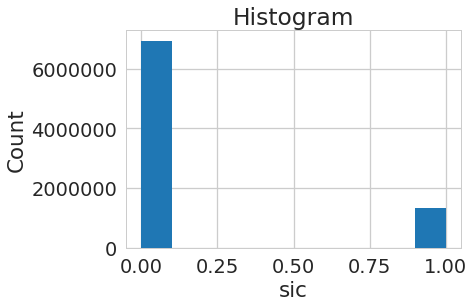

In [9]:
ds_out.plot()

# Plotting

In [10]:
sic_all = xr.open_mfdataset('/home/disk/sipn/nicway/data/model/nicosipn/forecast/sipn_nc/2018_08_Stereo.nc')
sic_all

<xarray.Dataset>
Dimensions:    (ensemble: 3, fore_time: 52, init_time: 1, ni: 448, nj: 304)
Coordinates:
  * init_time  (init_time) datetime64[ns] 2018-08-10
  * fore_time  (fore_time) timedelta64[ns] 0 days 1 days 2 days 3 days ...
  * nj         (nj) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * ni         (ni) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    lat        (nj, ni) float64 dask.array<shape=(304, 448), chunksize=(304, 448)>
    lon        (nj, ni) float64 dask.array<shape=(304, 448), chunksize=(304, 448)>
  * ensemble   (ensemble) int64 0 1 2
Data variables:
    sic        (init_time, ensemble, fore_time, nj, ni) float64 dask.array<shape=(1, 3, 52, 304, 448), chunksize=(1, 3, 52, 304, 448)>

Text(0.5,1,'Target Grid')

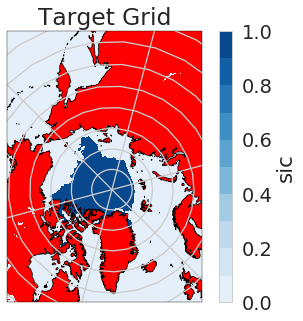

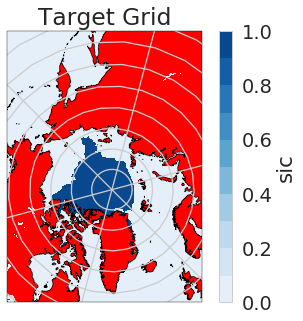

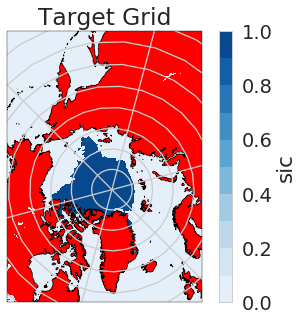

In [11]:

# Set up plotting info
cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10))
cmap_sic.set_bad(color = 'red')

# # Plot original projection
# plt.figure(figsize=(20,10))
# ax1 = plt.axes(projection=ccrs.PlateCarree())
# ds_p = ds.sic.isel(fore_time=8).isel(ensemble=0)
# ds_p.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
#                                  vmin=0, vmax=1,
#                                  cmap=matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10)),
#                     transform=ccrs.PlateCarree());
# ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
# gl = ax1.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
# gl.xlabels_bottom = True
# gl.ylabels_left = True
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER
# ax1.coastlines(linewidth=0.75, color='black', resolution='50m');

# # Plot SIC on target projection
# (f, ax1) = ice_plot.polar_axis()
# ds_p.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
#                                      transform=ccrs.PlateCarree(),
#                                      cmap=cmap_sic)
# ax1.set_title('Original Grid')

# Plot SIC on target projection
(f, ax1) = ice_plot.polar_axis()
ds_p2 = sic_all.sic.isel(init_time=0).isel(fore_time=8).isel(ensemble=0)
ds_p2.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_sic)
ax1.set_title('Target Grid')

(f, ax1) = ice_plot.polar_axis()
ds_p2 = sic_all.sic.isel(init_time=0).isel(fore_time=8).isel(ensemble=1)
ds_p2.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_sic)
ax1.set_title('Target Grid')

(f, ax1) = ice_plot.polar_axis()
ds_p2 = sic_all.sic.isel(init_time=0).isel(fore_time=8).isel(ensemble=2)
ds_p2.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_sic)
ax1.set_title('Target Grid')
